In [2]:
import matplotlib.pyplot as plt
import cv2
import os

from tensorflow.python.keras.utils.version_utils import callbacks
from tensorflow.python.ops.ragged.ragged_util import repeat

%matplotlib inline

In [3]:
DATA_DIR = os.path.join(os.getcwd(), "Content")
CATEGORIES = ["glioma_tumor","meningioma_tumor","no_tumor","pituitary_tumor"]
TRAINING_DIR = os.path.join(DATA_DIR, "Training")
TESTING_DIR = os.path.join(DATA_DIR, "Testing")
TRAINING_CLAHE_DIR = os.path.join(DATA_DIR, "Training_clahe")
TESTING_CLAHE_DIR = os.path.join(DATA_DIR, "Testing_clahe")
TRAINING_EDGE_DIR = os.path.join(DATA_DIR, "Training_edge")
TESTING_EDGE_DIR = os.path.join(DATA_DIR, "Testing_edge")

In [4]:
# Preprocess images using CLAHE
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image: {image_path}")
        return None
    gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale

    # Apply CLAHE
    clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8, 8))
    clahe_img = clahe.apply(gray_img)

    return clahe_img

# Preprocess the images of a directory
def process_images(input_dir, output_dir, process_func):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for category in CATEGORIES:
        category_path = os.path.join(input_dir, category)
        if not os.path.exists(category_path):
            print(f"Category path does not exist: {category_path}")
            continue

        output_category_path = os.path.join(output_dir, category)
        if not os.path.exists(output_category_path):
            os.makedirs(output_category_path)

        for image_name in os.listdir(category_path):
            image_path = os.path.join(category_path, image_name)
            processed_image = process_func(image_path)
            if processed_image is not None:
                output_image_path = os.path.join(output_category_path, image_name)
                cv2.imwrite(output_image_path, processed_image)

# Display images
def display_images(input_dir):
    for category in CATEGORIES:
        category_path = os.path.join(input_dir, category)
        if not os.path.exists(category_path):
            continue

        images = os.listdir(category_path)
        plt.figure(figsize=(12, 12))
        for i in range(min(3, len(images))):
            plt.subplot(1, 3, i + 1)
            img = plt.imread(str(os.path.join(category_path, images[i])))
            plt.imshow(img)
        plt.show()

# Edge detection using Canny edge detector
def edge_detection(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None

    blurred = cv2.GaussianBlur(img, (5, 5), 1.5)
    edges = cv2.Canny(blurred, threshold1=100, threshold2=200)
    return edges

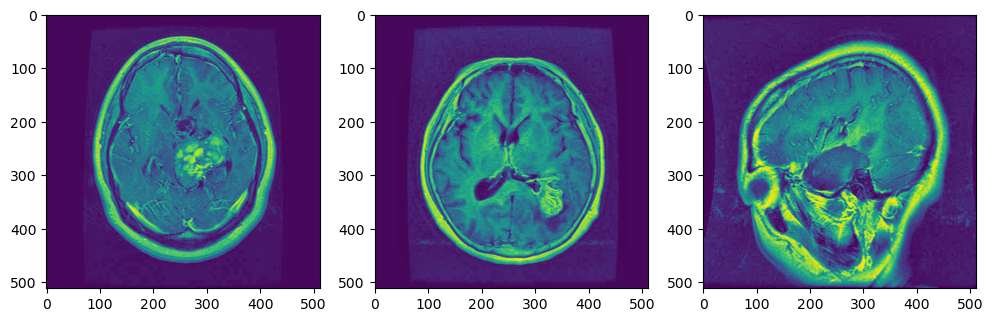

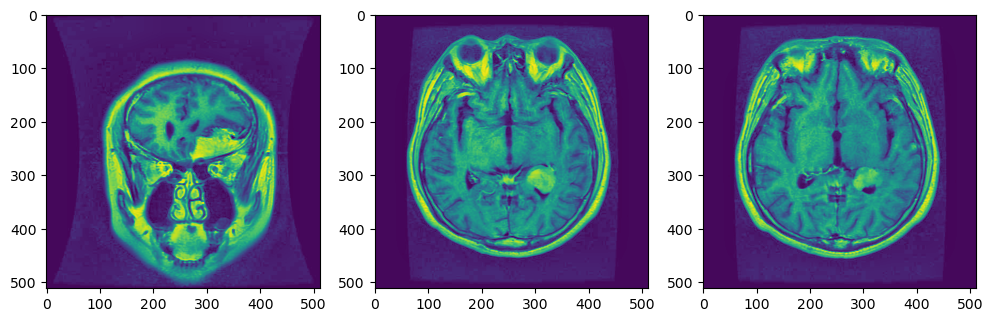

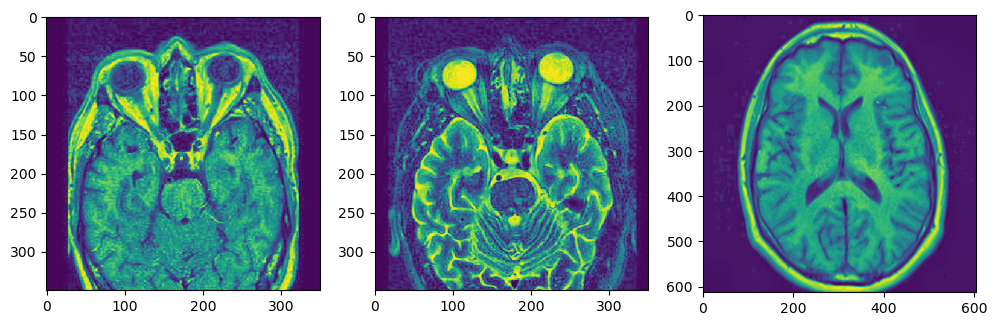

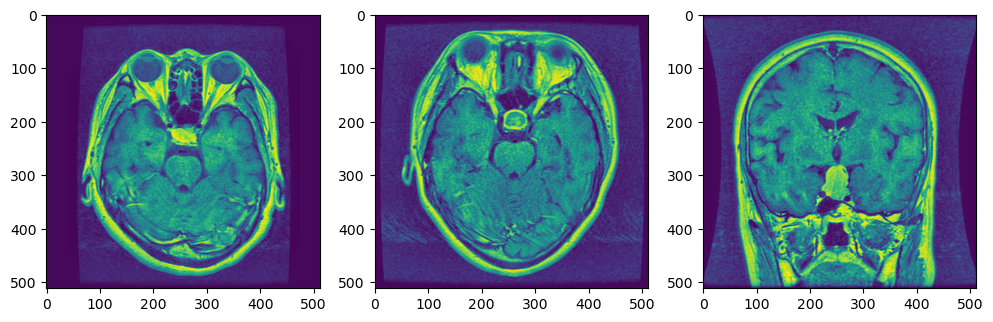

In [5]:
# Preprocess images using CLAHE
process_images(TRAINING_DIR, TRAINING_CLAHE_DIR, preprocess_image)
process_images(TESTING_CLAHE_DIR, TESTING_CLAHE_DIR, preprocess_image)
display_images(TRAINING_CLAHE_DIR)

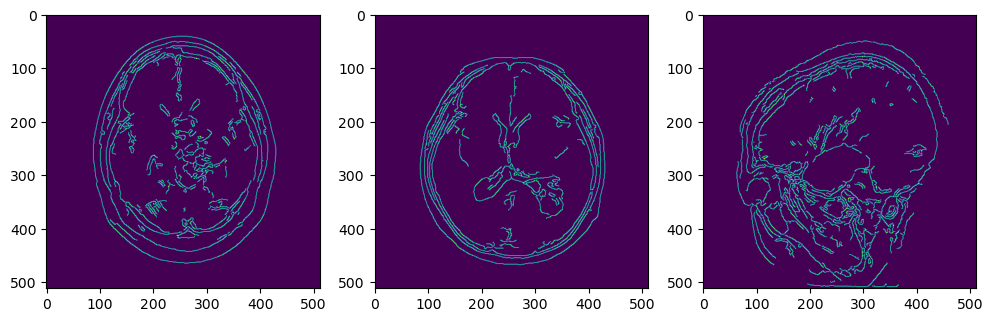

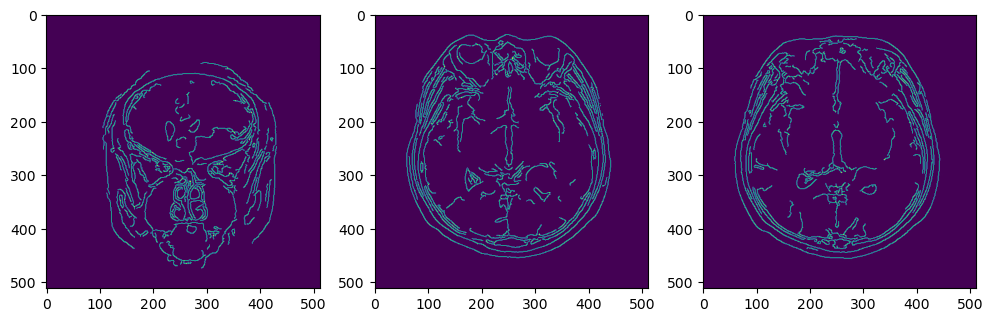

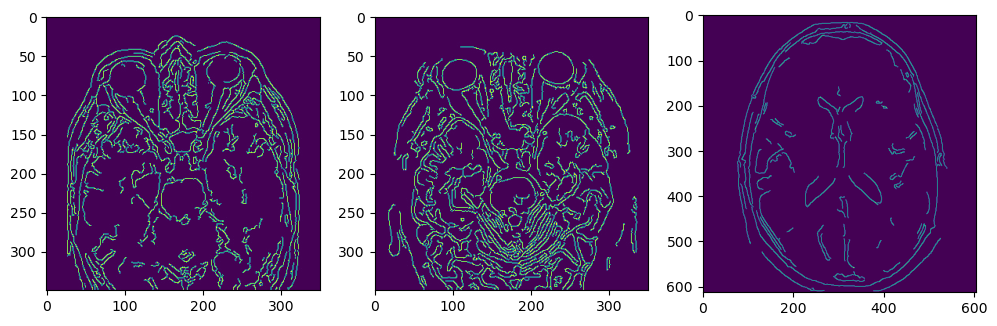

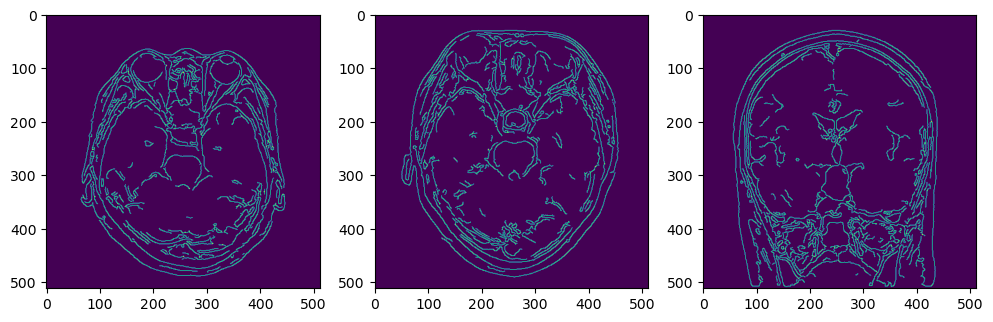

In [6]:
# Edge detection using Canny edge detector
process_images(TRAINING_CLAHE_DIR, TRAINING_EDGE_DIR, edge_detection)
process_images(TESTING_CLAHE_DIR, TESTING_EDGE_DIR, edge_detection)
display_images(TRAINING_EDGE_DIR)

In [141]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [143]:
# Create image generator for training and validation
train_datagen = ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.2,
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Creating generators
train_generator = train_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
)

validation_generator = train_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
)

Found 2297 images belonging to 4 classes.
Found 573 images belonging to 4 classes.


In [147]:
# Build the model
model = Sequential([
    Input(shape=(224, 224, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(len(CATEGORIES), activation='softmax')
])

In [149]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │      44,302,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 44,398,148 (169.37 MB)

 Trainable params: 44,398,148 (169.37 MB)

 Non-trainable params: 0 (0.00 B)

In [151]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10,
)

C:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 61s 824ms/step - accuracy: 0.4813 - loss: 1.3029 - val_accuracy: 0.4301 - val_loss: 1.1637
Epoch 2/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6875 - loss: 0.7863 - val_accuracy: 0.4138 - val_loss: 1.2642
Epoch 3/10


C:\Users\ASUS\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


71/71 ━━━━━━━━━━━━━━━━━━━━ 60s 840ms/step - accuracy: 0.7448 - loss: 0.6020 - val_accuracy: 0.5221 - val_loss: 1.1630
Epoch 4/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6875 - loss: 1.0950 - val_accuracy: 0.5862 - val_loss: 0.8078
Epoch 5/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 58s 818ms/step - accuracy: 0.8719 - loss: 0.3450 - val_accuracy: 0.6581 - val_loss: 0.9891
Epoch 6/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8750 - loss: 0.2493 - val_accuracy: 0.6552 - val_loss: 1.0665
Epoch 7/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 60s 846ms/step - accuracy: 0.9163 - loss: 0.2223 - val_accuracy: 0.6029 - val_loss: 1.2071
Epoch 8/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8438 - loss: 0.3658 - val_accuracy: 0.5517 - val_loss: 1.4575
Epoch 9/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 62s 876ms/step - accuracy: 0.9519 - loss: 0.1348 - val_accuracy: 0.6176 - val_loss: 1.1628
Epoch 10/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9062 - loss: 0.1436 - val_accuracy: 0.6897 - val_los

In [155]:
# Evaluate the model
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    TESTING_DIR,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc}")

Found 394 images belonging to 4 classes.
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 160ms/step - accuracy: 0.6301 - loss: 3.0629
Test accuracy: 0.6395938992500305
